<a href="https://colab.research.google.com/github/BREIMER606/Programaci-n-Cient-fica/blob/main/Lab1_Pct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCIENTIFIC COMPUTING – Lab_1

Breimer Meneses

# Context


Indoor localization is a fundamental challenge for applications in industrial, logistics, and autonomous navigation fields due to the limitations of conventional satellite technologies like GPS that have low precision in enclosed environments or with dense obstacles [1]. Ultra Wideband (UWB)-based systems have emerged as a promising solution thanks to their high temporal resolution and ability to mitigate multipath effects, offering precise position estimates at relatively low costs [2]. However, the presence of Non-Line-of-Sight (NLOS) conditions and reflections cause significant biases and errors in distance measurements, degrading the reliability of localization systems [3]. Figure 1 illustrates the spatial trajectory of a drone obtained from our experimental setup using a UWB-based localization system, highlighting complex movement patterns and environmental influences captured in the dataset. To overcome these challenges, sensor data fusion techniques are used to integrate complementary measurements from inertial sensors, UWB, and odometry, improving accuracy and robustness by leveraging the advantages of each modality. Moreover, machine learning algorithms are increasingly applied to model complex propagation phenomena and residual errors that traditional methods cannot fully capture, enabling adaptive, data-driven corrections that enhance localization performance in dynamic and congested indoor environments [4] [5].

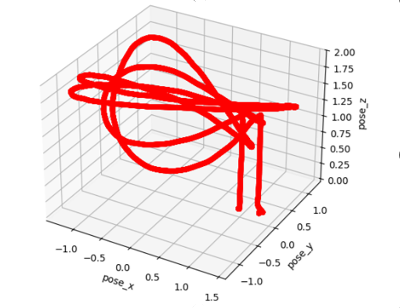

*Figure 1. 3D trajectory recorded by the drone on the (x, γ, z) axes. Source: Own elaboration, based on the file const1-trial2-tdoa2.csv*



# Database description

The recorded dataset includes synchronized measurements of the drone's three-dimensional pose coordinates (unknown ,x, y, z) along with inertial sensor data, such as accelerations and angular velocities, as well as environmental parameters like barometric pressure. These multi-modal data streams allow for comprehensive modeling and analysis of the drone's motion dynamics, as well as of the UWB signal propagation characteristics under real indoor conditions.

In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy.signal import butter, filtfilt
import math

In [25]:
# Import data set
df = pd.read_csv('const1-trial2-tdoa2.csv')

cols = df.columns.values.reshape(9, 3)
print(cols)

[['t_tdoa' 'idA' 'idB']
 ['tdoa_meas' 't_acc' 'acc_x']
 ['acc_y' 'acc_z' 't_gyro']
 ['gyro_x' 'gyro_y' 'gyro_z']
 ['t_tof' 'tof' 't_flow']
 ['deltaX' 'deltaY' 't_baro']
 ['baro' 't_pose' 'pose_x']
 ['pose_y' 'pose_z' 'pose_qx']
 ['pose_qy' 'pose_qz' 'pose_qw']]


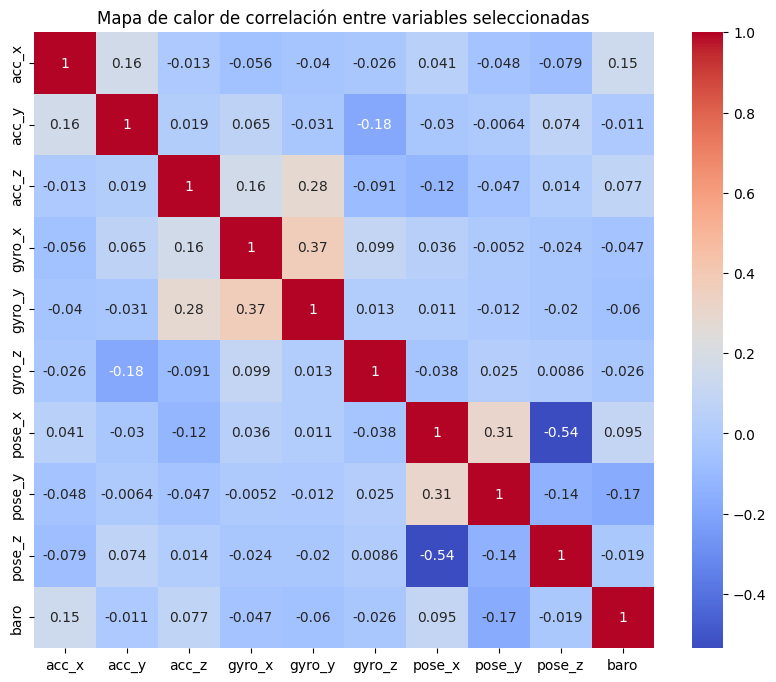

In [20]:
corr = df[['acc_x','acc_y','acc_z',
           'gyro_x','gyro_y','gyro_z',
           'pose_x','pose_y','pose_z',
           'baro']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Mapa de calor de correlación entre variables seleccionadas")
plt.show()

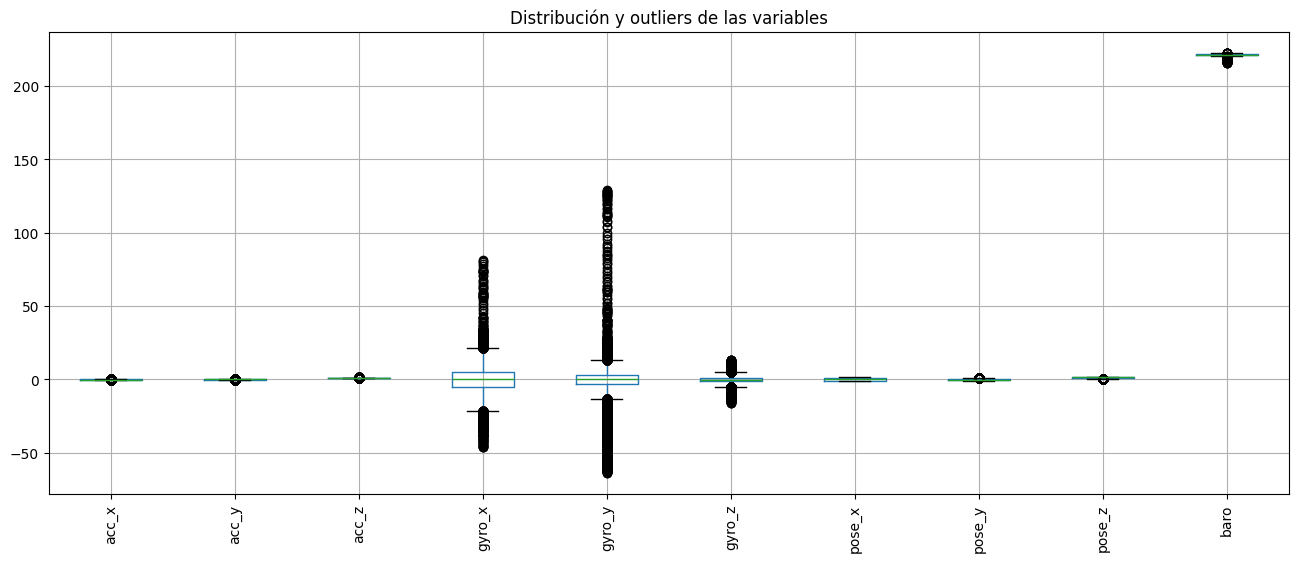

In [22]:
vars_a_mostrar = [
    'acc_x', 'acc_y', 'acc_z',
    'gyro_x', 'gyro_y', 'gyro_z',
    'pose_x', 'pose_y', 'pose_z',
    'baro'
]

df[vars_a_mostrar].boxplot(figsize=(16,6))
plt.xticks(rotation=90)
plt.title("Distribución y outliers de las variables")
plt.show()


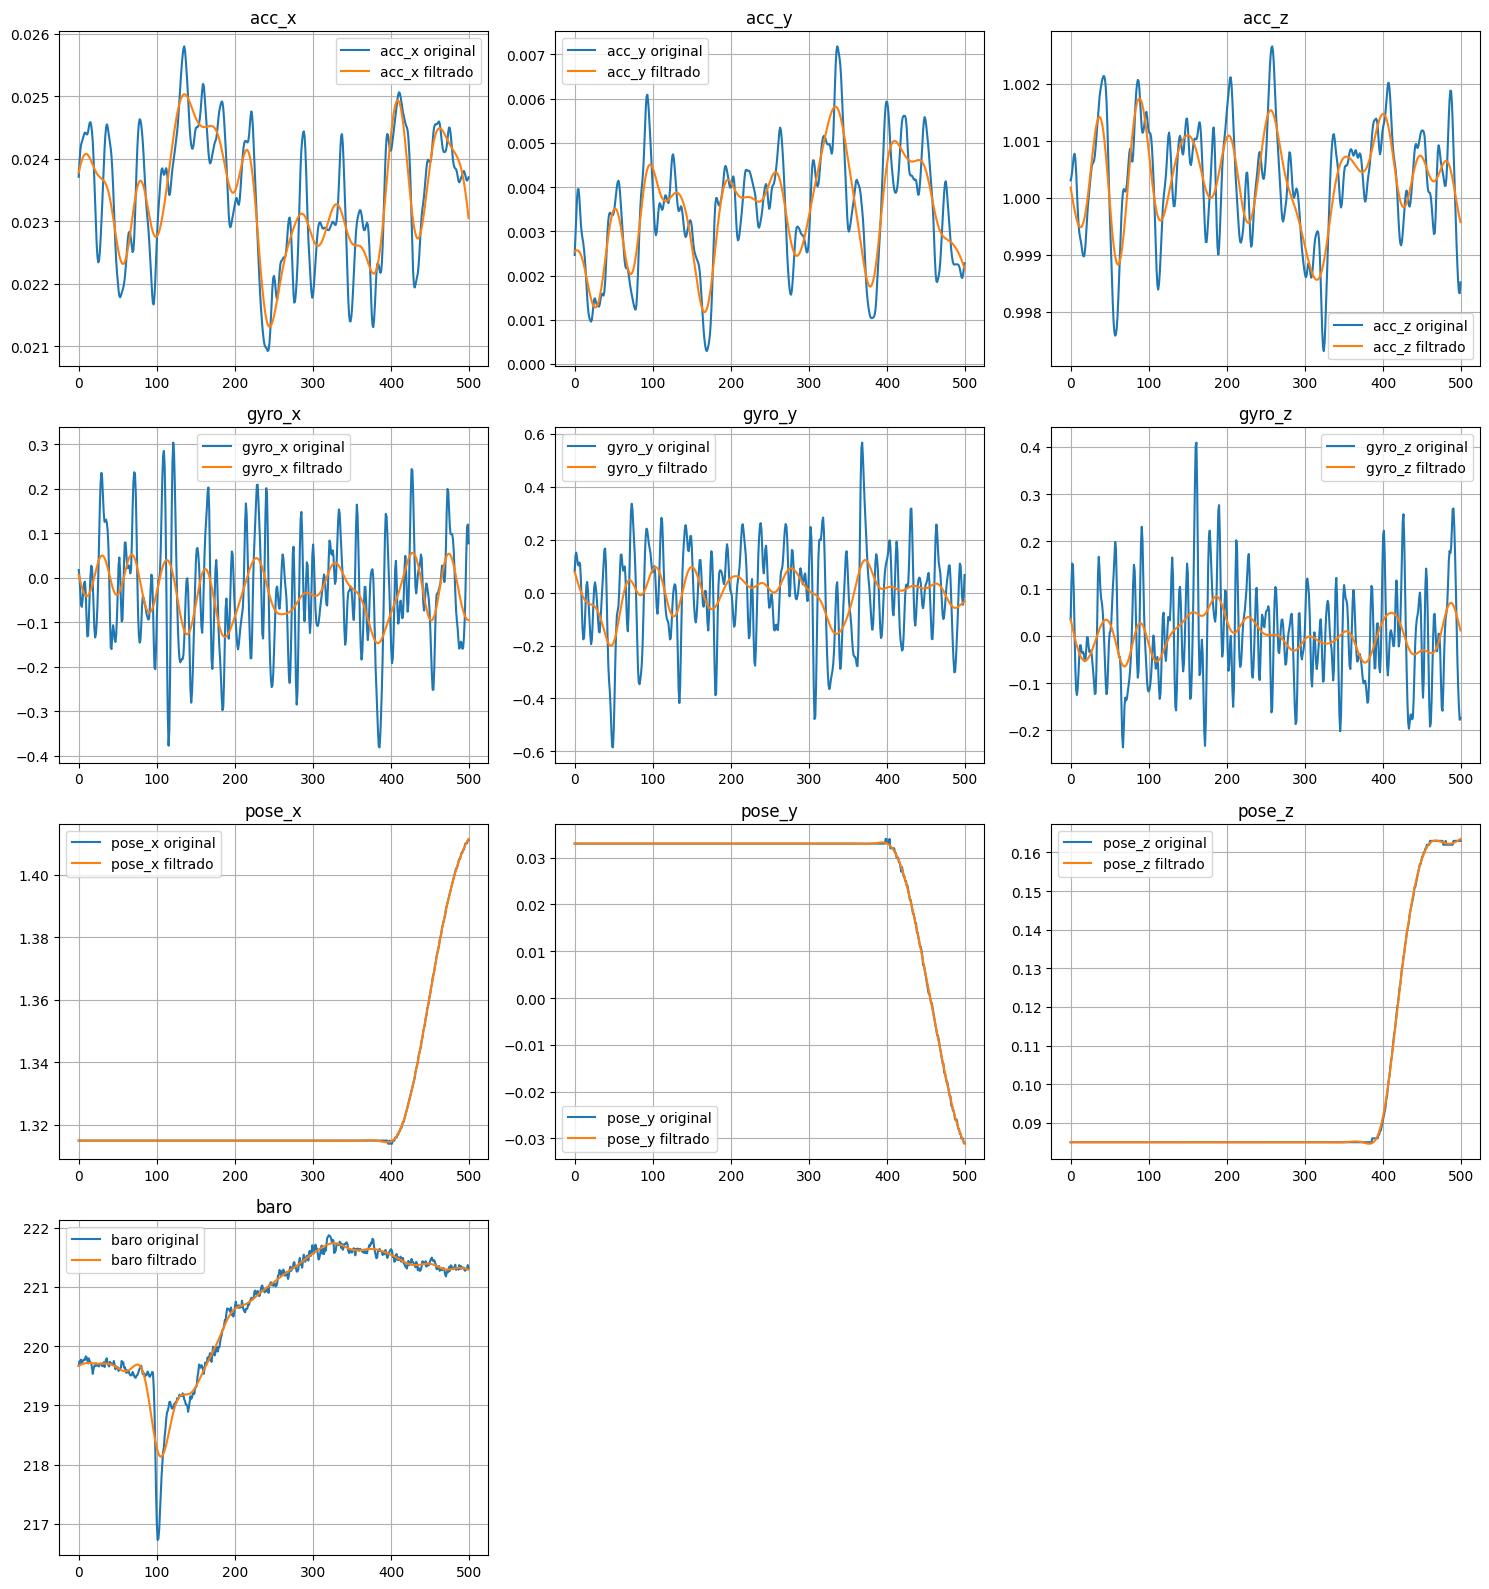

In [24]:

class DatasetProcessor:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.filtered = False

    def filtro_butter(self, data, order=4, fs=100, cutoff=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    def aplicar_filtro(self, columnas, order=4, cutoff=5):
        columnas_a_usar = columnas + ['t_pose'] if 't_pose' in self.df.columns else columnas
        self.df = self.df.dropna(subset=columnas_a_usar)

        tiempo = self.df['t_pose'].values
        fs = 1 / np.mean(np.diff(tiempo))
        self.fs = fs

        for col in columnas:
            self.df[col + '_filt'] = self.filtro_butter(self.df[col], order=order, fs=fs, cutoff=cutoff)

        self.filtered = True

    def graficar_comparacion_varias(self, variables, num_puntos=500, cols=3):
        if not self.filtered:
            print("Advertencia: Aún no se ha aplicado filtro. Usa aplicar_filtro() primero.")
            return

        num_vars = len(variables)
        rows = math.ceil(num_vars / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        axes = axes.flatten()

        for i, variable in enumerate(variables):
            ax = axes[i]
            ax.plot(self.df[variable].values[:num_puntos], label=f'{variable} original')
            ax.plot(self.df[variable + '_filt'].values[:num_puntos], label=f'{variable} filtrado')
            ax.set_title(variable)
            ax.legend()
            ax.grid(True)
        
        for j in range(i+1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

# Columnas físicas a filtrar excluyendo marcas de tiempo
columnas_a_filtrar = [
    'acc_x', 'acc_y', 'acc_z',
    'gyro_x', 'gyro_y', 'gyro_z',
    'pose_x', 'pose_y', 'pose_z',
    'baro'
]

processor = DatasetProcessor('const1-trial2-tdoa2.csv')
processor.aplicar_filtro(columnas_a_filtrar)

processor.graficar_comparacion_varias(columnas_a_filtrar, num_puntos=500, cols=3)


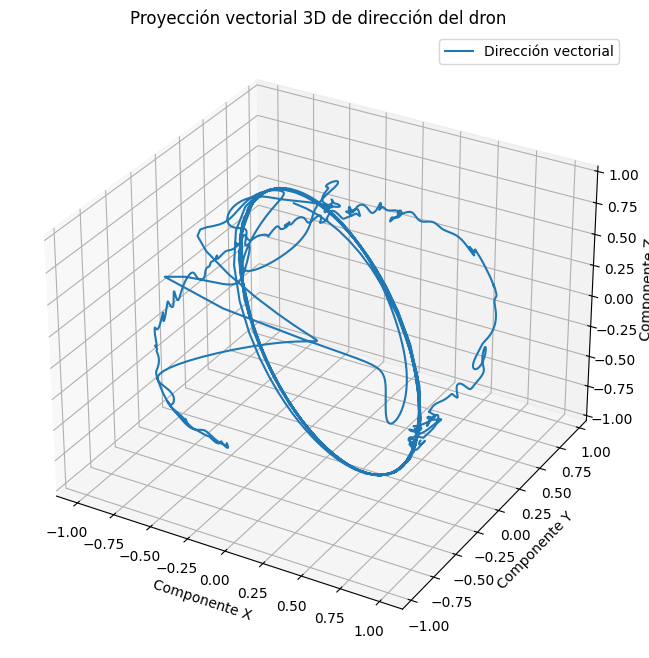

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necesario para gráficos 3D
import numpy as np

# Calcular velocidad en x,y,z, componente filtrada (índice 1)
vel_x = processor.calcular_velocidad('pose_x', filtrado=True)[1]
vel_y = processor.calcular_velocidad('pose_y', filtrado=True)[1]
vel_z = processor.calcular_velocidad('pose_z', filtrado=True)[1]

# Vector velocidad y normalización para obtener dirección unitaria
vel_vect = np.vstack((vel_x, vel_y, vel_z)).T
magnitudes = np.linalg.norm(vel_vect, axis=1, keepdims=True)
magnitudes[magnitudes == 0] = 1
direcciones = vel_vect / magnitudes

# Graficar en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar trayectoria 3D de la dirección
ax.plot(direcciones[:, 0], direcciones[:, 1], direcciones[:, 2], label='Dirección vectorial')

# Etiquetas y leyenda
ax.set_xlabel('Componente X')
ax.set_ylabel('Componente Y')
ax.set_zlabel('Componente Z')
ax.set_title('Proyección vectorial 3D de dirección del dron')
ax.legend()
plt.show()


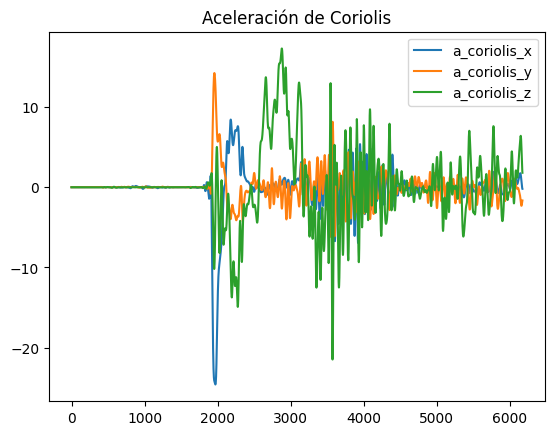

In [44]:
# Obtener velocidades angulares con filtro
omega_x = processor.df['gyro_x_filt'].values
omega_y = processor.df['gyro_y_filt'].values
omega_z = processor.df['gyro_z_filt'].values

# Obtener velocidades lineales (filtradas, ya calculadas)
v_x = processor.calcular_velocidad('pose_x', filtrado=True)[1]
v_y = processor.calcular_velocidad('pose_y', filtrado=True)[1]
v_z = processor.calcular_velocidad('pose_z', filtrado=True)[1]

# Armar vectores
omega = np.vstack((omega_x, omega_y, omega_z)).T
v = np.vstack((v_x, v_y, v_z)).T

# Calcular aceleración de Coriolis en cada instante (producto vectorial * 2)
a_coriolis = 2 * np.cross(omega, v)

# Puedes graficar componentes de a_coriolis
import matplotlib.pyplot as plt
plt.plot(a_coriolis[:, 0], label='a_coriolis_x')
plt.plot(a_coriolis[:, 1], label='a_coriolis_y')
plt.plot(a_coriolis[:, 2], label='a_coriolis_z')
plt.legend()
plt.title('Aceleración de Coriolis')
plt.show()


In [ ]:

# 6. Discusión y conclusiones

# conclusiones
# - La normalización y el promedio móvil permiten limpiar el ruido.
# - La derivada muestra las variaciones rápidas en la señal.
# - El área bajo la curva representa una medida de energía acumulada.
# - Los valores propios de la matriz nos muestran la contribución
#   de cada componente en la variabilidad de los datos.


# References

[1] F. Zafari et al., "A Survey of Indoor Localization Systems and Technologies," IEEE Communications Surveys & Tutorials, 2019.

[2] V. Barral et al., "NLOS Classification Based on RSS and Ranging Statistics Obtained from Low-Cost UWB Devices," 2019.

[3]I. Güvenç et al., "NLOS Identification and Weighted Least Squares Localization for UWB Systems," EURASIP Journal on Advances in Signal Processing, 2008.

[4] J. Khodjaev et al., "Survey of NLOS Identification and Error Mitigation Problems in UWB Positioning Algorithms," Annals of Telecommunications, 2010.

[5] H. Wymeersch et al., "A Machine Learning Approach to Ranging Error Mitigation for UWB Localization," IEEE Transactions on Communications, 2012.